## I wanted to see more interesting airplanes, so I wrote some python and spun up a Linux box on AWS.

My inspiration for this project came from a [Pycon talk](https://www.youtube.com/watch?v=bK2iPDu7RDE&ab_channel=PyConUS) by Jessica Garson.  Jessica used python to send herself a text each day to figure out if she needed to move her car based on New York City parking regulations.

Since I love airplanes so much, I wanted to receive a notification around sunset with all of the interesting planes about to arrive into Phoenix Sky Harbor airport.  I live in a spot with a great view of the arrival flight pattern, so I frequenly notice planes.  However, Phoenix doesn't have great diversity when it comes to airplanes.  The majority are Boeing 737s and Airbus A320s.  I've seen so many of these over the years, I would like my attention drawn to other interesting planes, such as a lumbering Airbus A330, or a sleek Boeing 757, or a nostalgic Boeing 747.

#### To pull this off I needed to gather several pieces of information:
1. run a cron job once a day to:
 - find the time of sunset for the current day and my current location
 - back up from sunset by 10 minutes (this is somewhat arbitrary, it just gives me a little more time to decide if any incoming planes are interesting, and coordinate some outdoor activity such as a walk to the grocery store)

1. at sunset minus 10 minutes fetch all incoming flights and exclude the most common aircraft models that arrive at the PHX airport.
 
1. send myself a text with interesting aircraft models, along with other interesting information such as the airport of origin

In [35]:
# import libraries
import requests
import pandas as pd
import datetime
from dateutil.parser import parse
import os
from twilio.rest import Client
from passwords import *

## Find Sunset for the current day

- this code gets run once a day at noon using a cron job
- it schedules an "at" job to run at sunset minus 10 minutes each day

In [2]:
# find today's date
current_date = str(datetime.datetime.today().date())

# assign variables for latitude and longitude
scottsdale_latitude='33.4942'
scottsdale_longitude='-111.9261'

# api call
sunset = requests.get(f'https://api.sunrise-sunset.org/json?lat={scottsdale_latitude}&lng={scottsdale_longitude}&formatted=0&date={current_date}')

# extract UTC time
sunset = sunset.json()['results']['sunset']

# back up from sunset by 10 minutes
sunset = parse(sunset) - pd.Timedelta(10, unit ='m')

# add time to string and schedule "at" job
sunset_job = f'echo python3 "flight_data.py" | at "{str(sunset)[11:16]}"'
sunrise_job = f'echo python3 "flight_data.py" | at "{str(sunrise)[11:16]}"'

# create "at" job
os.system(sunset_job)
os.system(sunrise_job)

In [3]:
str(sunset)

'2021-05-09 02:06:31+00:00'

## Fetch Incoming Flight Data
- this code is triggered using the above scheduled "at" job

In [36]:
# read in data from website for Sky Harbor Airport
airport = 'KPHX'

df = pd.read_html(f'https://flightaware.com/live/airport/{airport}/enroute')[2]

# remove stacked column levels
df.columns = df.columns.droplevel()

# exclude uninteresting planes
common_planes = [
    'B73',
    'A32',
    'CRJ'
]

# filter out cases where no departure time or aircraft type identification is given
df = df[~df.Type.fillna('None').str.contains('|'.join(common_planes))].dropna(subset=['Departure'])

In [37]:
df

,Ident,Type,Origin,ScheduledDeparture Time,Departure,EstimatedArrival Time,Unnamed: 6_level_1,Unnamed: 7_level_1
9,SWA1890,B38M,Los Angeles Intl (KLAX),Sat 07:50PM PDT,Sat 08:14PM PDT,Sat 09:07PM MST,NaN,NaN
11,FFT2823,A20N,Colorado Sprgs Muni (KCOS),Sat 08:45PM MDT,Sat 08:47PM MDT,Sat 09:15PM MST,NaN,NaN
15,SKW3906,E75L,Los Angeles Intl (KLAX),Sat 08:30PM PDT,Sat 08:36PM PDT,Sat 09:37PM MST,NaN,NaN
17,SWA3044,B38M,Baltimore/Washington Intl (KBWI),Sat 08:00PM EDT,Sat 08:00PM EDT,Sat 09:41PM MST,NaN,NaN


## Send myself a text
- using a Twilio free trial account I send flights in the above dataframe to myself as a text
- to keep the text messages more concise, I have limited the message to only include:
 - aircraft type
 - estimated arrival time
 - 4 digit origin airport code

In [38]:
# format flight data into text message
msg = '\n'.join(df['Type'] + ' - ' + 
                df['EstimatedArrival Time'].str.slice(start=4, stop=11) + ' - ' + 
                df['Origin'].str.slice(start=-5, stop=-1))

# establish twilio credentials
client = Client(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)

# send text message
client.api.account.messages.create(
    to=MY_PHONE_NUMBER,
    from_=TWILIO_PHONE_NUMBER,
    body=msg);

In [39]:
# example message string
msg

'B38M - 09:07PM - KLAX\nA20N - 09:15PM - KCOS\nE75L - 09:37PM - KLAX\nB38M - 09:41PM - KBWI'

#### Example text message

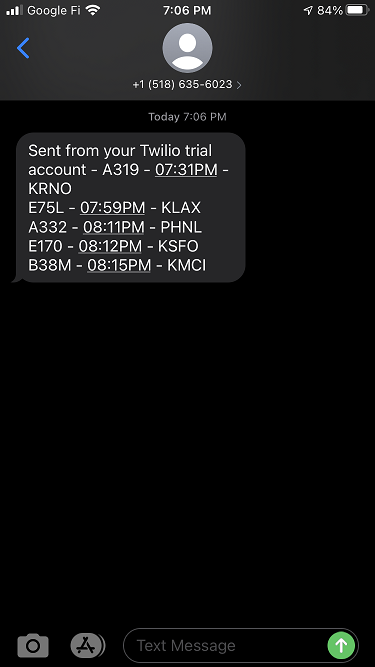

## Next things to consider

1. run a cron job at regular intervals to aggregate flight data over time (maybe a sqlite db?)
1. mine historical data to determine which aircraft types are the most rare
1. send myself ad hoc texts based on especially rare arrivals
1. is there a way to find especially interesting planes based on tail number (Ident), such as Airforce 1? I could place them on a list and get an ad hoc text when one of these planes arrive